## Imports

In [1]:
import pandas as pd
import numpy as np

from keras.models import Model, load_model
from keras.layers import Dense, Input, Concatenate, Lambda, regularizers, LeakyReLU, Softmax, Dropout, \
                         BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split

import seaborn as sns
sns.set(rc={'figure.figsize':(13.7,8.27)})

Using TensorFlow backend.


## Loading Data

### Training Data

In [2]:
# loading and processing data
df = pd.read_csv("train_.csv")
df["StateRepresentation"] = df["StateRepresentation"].apply(lambda x: np.fromstring(x[1:-1], sep=" "))
df["MovesEncoded"] = df["MovesEncoded"].apply(lambda x: np.fromstring(x[1:-1], sep=" "))
df["hashed"] = df["StateRepresentation"].apply(lambda s: s.tostring())
df = df.sort_values('Value', ascending=False).drop_duplicates('hashed').sort_index()

# preparing data for deep learing
max_val = 16
x_train = df.StateRepresentation.values
x_train = np.array([x / max_val for x in x_train])

y_train = df.Value.values
y_train = np.array([np.array([val], dtype=float) for val in y_train])

### Testing Data

In [4]:
# loading and processing data
df = pd.read_csv("test_.csv")
df["StateRepresentation"] = df["StateRepresentation"].apply(lambda x: np.fromstring(x[1:-1], sep=" "))
df["MovesEncoded"] = df["MovesEncoded"].apply(lambda x: np.fromstring(x[1:-1], sep=" "))
df["hashed"] = df["StateRepresentation"].apply(lambda s: s.tostring())
df = df.sort_values('Value', ascending=False).drop_duplicates('hashed').sort_index()

# preparing data for deep learing
max_val = 16
x_test = df.StateRepresentation.values
x_test = np.array([x / max_val for x in x_test])

y_test = df.Value.values
y_test = np.array([np.array([val], dtype=float) for val in y_test])

In [5]:
x_test.shape

(20486, 24)

## Building the Model 

In [14]:
# params
width = 4
height = 6

shared_weights = [32, 16]
connected_layers = [128, 64, 64]

learning_rate = 0.002
batch_size = 124
epochs = 50

directory = "Experiments/ValueFunction_03"

In [12]:
def build_model():
    inputArray = Input(shape=(24,))

    layer = inputArray

    shared_dense = Dense(shared_weights[0], activation='relu')
    layerArray = []

    for t in range(width):
        out = Lambda(lambda x: x[:, t*height:(t+1)*height])(layer)
        layerArray.append(shared_dense(out))

    layer = layerArray

    for neurons in shared_weights[1:]:
        shared_dense = Dense(neurons, activation='relu')
        layerArray = []
        for t in range(width):
            layerArray.append(shared_dense(layer[t]))
        layer = layerArray

    merged_vector = Concatenate(axis=-1)(layer)

    layer = merged_vector
    for neurons in connected_layers:
        layer = Dense(neurons, activation='relu')(layer)
        layer = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True)(layer)
    output_layer = Dense(1, activation='linear')(layer)
    model = Model(input=inputArray, output=output_layer)

    adam = Adam(lr=learning_rate)
    model.compile(optimizer=adam, loss='mse', metrics=['mae'])
    return model

In [8]:
tensorboard_cb = TensorBoard(log_dir=dir, histogram_freq=0,
                             write_graph=True, write_images=False)

checkpoint_cb = ModelCheckpoint(filepath=directory + "/model.hdf5", verbose=False)

early_stopping_cb = EarlyStopping(monitor='val_loss', min_delta=0, patience=6, verbose=0, mode='auto',
                                  baseline=None, restore_best_weights=True)

TypeError: unsupported operand type(s) for +: 'builtin_function_or_method' and 'str'

## Training the Model

In [ ]:
model = build_model()

In [139]:
model.fit(x_train, y_train,
               batch_size=batch_size,
               epochs=epochs,
               shuffle=True,
               callbacks=[tensorboard_cb, checkpoint_cb, early_stopping_cb],
               validation_split=0.2,
               verbose=1)

Train on 1214454 samples, validate on 303614 samples
Epoch 1/50
1214454/1214454 [==============================] - 47s 39us/step - loss: 0.9444 - mean_absolute_error: 0.6785 - val_loss: 0.5485 - val_mean_absolute_error: 0.5696
Epoch 2/50
1214454/1214454 [==============================] - 51s 42us/step - loss: 0.4856 - mean_absolute_error: 0.5406 - val_loss: 0.4253 - val_mean_absolute_error: 0.5114
Epoch 3/50
1214454/1214454 [==============================] - 50s 41us/step - loss: 0.4380 - mean_absolute_error: 0.5134 - val_loss: 0.5358 - val_mean_absolute_error: 0.5936
Epoch 4/50
1214454/1214454 [==============================] - 58s 47us/step - loss: 0.4194 - mean_absolute_error: 0.5025 - val_loss: 0.4053 - val_mean_absolute_error: 0.4762
Epoch 5/50
1214454/1214454 [==============================] - 57s 47us/step - loss: 0.4043 - mean_absolute_error: 0.4934 - val_loss: 0.3368 - val_mean_absolute_error: 0.4389
Epoch 6/50
1214454/1214454 [==============================] - 50s 41us/step -

KeyboardInterrupt: 

# Loading a Model

In [15]:
model = build_model()
try:
    model.load_weights(filepath=directory + "/model.hdf5")
    print("Loading existing model.")
except OSError:
    print("No existing model found.")

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Loading existing model.


## First Evaluation

In [16]:
model.evaluate(x_test, y_test)

20486/20486 [==============================] - 1s 31us/step


[0.3847253396268816, 0.4454872466199719]

In [17]:
y_pred = [x[0] for x in model.predict(x_test)]

In [18]:
comparison_df = pd.DataFrame(y_test)
comparison_df["pred"] = y_pred
comparison_df.comlumns = ["Y_true", "Y_pred"]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
comparison_df = comparison_df.rename(index=str, columns={0: "Y_true", "pred": "Y_pred"})

In [20]:
comparison_df["resid"] = comparison_df["Y_true"] - comparison_df["Y_pred"]
comparison_df["resid_abs"] = comparison_df["resid"].abs()

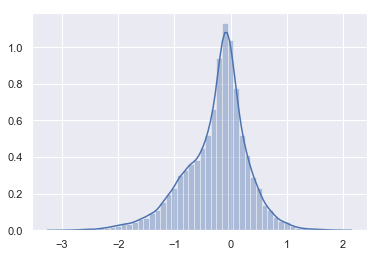

In [21]:
sns.distplot(comparison_df.resid.values);

## Numerical Analysis of Residuals

In [22]:
np.quantile(comparison_df.resid, 0.95)

0.5466172695159912

In [23]:
np.quantile(comparison_df.resid, 0.05)

-1.2918877601623535

In [24]:
comparison_df.resid.describe()

count    20486.000000
mean        -0.256115
std          0.564930
min         -3.057046
25%         -0.555565
50%         -0.158615
75%          0.077137
max          1.955508
Name: resid, dtype: float64

## Analysis of Residuals by Number of Steps Left

In [25]:
comparison_df.groupby("Y_true")["resid_abs"].count()

Y_true
-19.0       1
-18.0       4
-17.0      17
-16.0      45
-15.0     103
-14.0     227
-13.0     410
-12.0     665
-11.0    1011
-10.0    1331
-9.0     1578
-8.0     1770
-7.0     1886
-6.0     1955
-5.0     1985
-4.0     1994
-3.0     1997
-2.0     1978
-1.0     1529
Name: resid_abs, dtype: int64

In [26]:
comparison_df.groupby("Y_true")["resid_abs"].mean()

Y_true
-19.0    3.030017
-18.0    1.986135
-17.0    1.736172
-16.0    1.419248
-15.0    1.151436
-14.0    0.996425
-13.0    0.919618
-12.0    0.807101
-11.0    0.722654
-10.0    0.665657
-9.0     0.604930
-8.0     0.537456
-7.0     0.488748
-6.0     0.434204
-5.0     0.394925
-4.0     0.324326
-3.0     0.261929
-2.0     0.177442
-1.0     0.108268
Name: resid_abs, dtype: float64

In [31]:
test = comparison_df.groupby("Y_true")["resid_abs"].std()

In [37]:
import pickle

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb+') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

d = dict(test)
save_obj(d, "4x4_std")

In [38]:
b = load_obj("4x4_std")

In [39]:
b

{-19.0: nan,
 -18.0: 0.6028807945457002,
 -17.0: 0.7369845923013674,
 -16.0: 0.6846653838167049,
 -15.0: 0.6891206841115175,
 -14.0: 0.6266816590013624,
 -13.0: 0.5846226677396286,
 -12.0: 0.5493689183536612,
 -11.0: 0.5340542125782649,
 -10.0: 0.48275882097559847,
 -9.0: 0.45762485248100787,
 -8.0: 0.4090243764541133,
 -7.0: 0.3910051686716713,
 -6.0: 0.3593232171407749,
 -5.0: 0.3303540529214737,
 -4.0: 0.2753152315317095,
 -3.0: 0.231344060331559,
 -2.0: 0.1593059582186562,
 -1.0: 0.09421208115392851}

In [30]:
comparison_df.groupby("Y_true")["resid_abs"].min()

Y_true
-19.0    3.030017
-18.0    1.437910
-17.0    0.109060
-16.0    0.395867
-15.0    0.021416
-14.0    0.002564
-13.0    0.004539
-12.0    0.000348
-11.0    0.000913
-10.0    0.000154
-9.0     0.000299
-8.0     0.000613
-7.0     0.000684
-6.0     0.000200
-5.0     0.000129
-4.0     0.000144
-3.0     0.000647
-2.0     0.000059
-1.0     0.000029
Name: resid_abs, dtype: float64